In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=5c19b5a9acf320bda31fb76e0e190dae62f06e0b6184ef911b6def7ed86bdb49
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg
import keras as keras

import torch
import torch.nn as nn
import torch.optim as optim 

import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms, datasets

import PIL

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from efficientnet_pytorch import EfficientNet

In [3]:
# mount my drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd gdrive/MyDrive/Colab Notebooks/

/content/gdrive/MyDrive/Colab Notebooks


## Create model and load weights

In [6]:
# make model
model = EfficientNet.from_pretrained('efficientnet-b5', include_top=True)

# replace classification head

model._fc = nn.Sequential(
    # nn.Linear(1280, 512), 
    # nn.Linear(1536, 512), #b3
    nn.Linear(2048, 512), #b5
    # nn.Linear(2560, 512), #b7
    nn.Linear(512, 1))
model.cuda()
model._fc

Loaded pretrained weights for efficientnet-b5


Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=1, bias=True)
)

In [7]:
# load weights
PATH_best = './b5_unweighted_best.pt'
checkpoint = torch.load(PATH_best)
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Below is code for creating data loaders and running eval

In [8]:
# Load data

def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  

params_dict = {
        # Coefficients:   res
        'b0': [224, 224],
        'b1': [240, 240],
        'b2': [260, 260],
        'b3': [300, 300],
        'b4': [380, 380],
        'b5': [456, 456],
        'b6': [528, 528],
        'b7': [600, 600],
        'b8': [672, 672],
        'l2': [800, 800],
    }

def set_loader(optmean, optstd, data_folder, en_model='b1', weighted=True, batch_size=32):
    mean = eval(optmean)
    std = eval(optmean)
    inputsize = params_dict[en_model]

    train_transform = transforms.Compose([
        transforms.Resize(inputsize), #ENb1 input size
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    val_transform = transforms.Compose([
        transforms.Resize(inputsize), #ENb1 input size
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    train_dataset = datasets.ImageFolder(root=data_folder+"/train",
                                        transform=train_transform)
    val_dataset = datasets.ImageFolder(root=data_folder+"/val",
                                        transform=val_transform)
    test_dataset = datasets.ImageFolder(root=data_folder+"/test",
                                        transform=val_transform)

    weights = make_weights_for_balanced_classes(train_dataset.imgs, len(train_dataset.classes))                                                                
    weights = torch.DoubleTensor(weights)                                       
    sampler = utils.sampler.WeightedRandomSampler(weights, len(weights))                     

    if weighted:
      train_loader = torch.utils.data.DataLoader(
          train_dataset, batch_size=batch_size, sampler=sampler,
          num_workers=4)
    else:  
      train_loader = torch.utils.data.DataLoader(
          train_dataset, batch_size=batch_size, shuffle=True,
          num_workers=4)
      
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=4)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=4)

    return train_loader, val_loader, test_loader

In [9]:
# ct is class 0
train_loader, val_loader, test_loader = set_loader(optmean="(0.5553, 0.5080, 0.4960)", optstd="(0.1844, 0.1982, 0.2017)", data_folder="./ct_25_65", en_model='b5', weighted=False)

In [10]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        out = torch.flatten(torch.sigmoid(outputs))
        predicted = (out>0.5).int()
        correct += ((predicted == labels).sum().item())
        total += labels.size(0)

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 81 %


In [ ]:
# ct is class 0

model.eval()
thresholds = range(0.5, 0.8, 0.05)

for threshold in thresholds:
  print(f"THRESHOLD: {threshold}")
  print()
  tn, tp, fn, fp = 0, 0, 0, 0
  for im, labels in test_loader:
          labels = labels.cuda()
          im = im.cuda()
          outputs = model(im)
          out = torch.flatten(torch.sigmoid(outputs))
          predicted = (out>threshold).int()
          for i in range(len(predicted)):
            if predicted[i]==1 and labels[i]==1:
              tn += 1
            if predicted[i]==0 and labels[i]==0:
              tp += 1
            if predicted[i]==1 and labels[i]==0:
              fn += 1
            if predicted[i]==0 and labels[i]==1:
              fp += 1

  print("    label, pos-neg")
  print("pred, pos", tp, fp)
  print("pred, neg", fn, tn)

  print()
  print(f"Recall: {tp/(tp+fn)}")
  print(f"Precision: {tp/(tp+fp)}")
  print("-------------------------")

THRESHOLD: 0.8

    label, pos-neg
pred, pos 56 17
pred, neg 0 6

Recall: 1.0
Precision: 0.7671232876712328
-------------------------


In [ ]:
outs = []
l=[]

model.eval()

for im, labels in test_loader:
    labels = labels.cuda()
    im = im.cuda()
    outputs = model(im)
    out = torch.flatten(torch.sigmoid(outputs))
    outs.append(out)
    l.append(labels)
    outlist = torch.cat(outs, dim=0) 
    llist = torch.cat(l, dim=0)

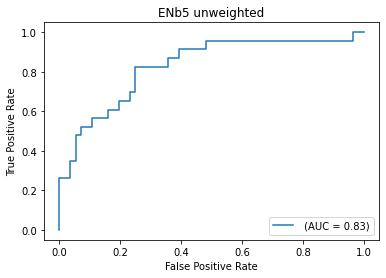

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

y = llist.cpu().detach().numpy()
preds = outlist.cpu().detach().numpy()
fpr, tpr, thresholds = roc_curve(y, preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="")
display.plot()
plt.title("ENb5 unweighted")
plt.show()